## 2025 Updates
Re-run analyses created by Anthony, plus add additional.

Summary:
- Re-run models, adding computation time analysis
- Add comparison models supported by literature
- Increase robustness of error analysis (when do errors occur, any factors, etc.)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error

#import keras_tuner as kt
from util import TEXT_COLUMNS, TARGET_COLUMNS, save_model, get_model_info
import os
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

2025-03-27 15:33:46.987381: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-27 15:33:47.137397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743107627.187226 4015027 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743107627.200760 4015027 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743107627.308632 4015027 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
FILE = 'data/encoded_model_data.csv'

# Tokenize and pad all text columns together
max_length = 30
tokenizer = Tokenizer(oov_token='<UNK>')
df = pd.read_csv(FILE)
df.reset_index(drop=True, inplace=True)
df.head()

Unnamed: 0  properties.delay  properties.length  properties.level  \
0           0          0.916667           1.606865               1.0   
1           1          0.716667           1.468921               1.0   
2           2          0.883333           1.468921               1.0   
3           3          1.783333           0.264083               4.0   
4           4          1.600000           0.382765               3.0   

   properties.speed  properties.day_of_week  properties.weekday_weekend  \
0         41.209406                       3                           0   
1         43.129446                       3                           0   
2         39.954234                       3                           0   
3          7.673947                       1                           0   
4         11.420821                       4                           0   

           X          Y  MaxInjuryS  ... SNOW/ICE SLUSH  two_way divided  \
0 -73.089829  40.815078           0  ...        0     0        0       0   
1 -73.089829  40.815078           0  ...        0     0        0       0   
2 -73.089829  40.815078           0  ...        0     0        0       0   
3 -73.668751  40.987908           0  ...        0     0        0       0   
4 -73.964869  41.521188           3  ...        0     0        1       1   

   protected_medium  CLOUDY  CLEAR  RAIN  SLEET/HAIL/FREEZING RAIN  SNOW  
0                 0       1      0     0                         0     0  
1                 0       1      0     0                         0     0  
2                 0       1      0     0                         0     0  
3                 0       0      1     0                         0     0  
4                 0       0      1     0                         0     0  

[5 rows x 49 columns]

In [5]:
# Combine text data from all columns
combined_text = df[TEXT_COLUMNS].apply(tuple, axis=1)
combined_text = combined_text.str.join(', ').values

# Fit tokenizer to the combined text
tokenizer.fit_on_texts(combined_text)

# Tokenize and pad each text column individually
padded_sequences_list = []
vocab_size = len(tokenizer.word_index) + 1
for col in TEXT_COLUMNS:
    sequences = tokenizer.texts_to_sequences(df[col])
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
    padded_sequences_list.append(padded_sequences)

# Numerical columns
num_col = [col for col in df.columns if (col not in TEXT_COLUMNS) and ('Unnamed' not in col) and (col not in TARGET_COLUMNS)]

In [6]:
# Prepare data for training
seed = 87
test_split = 0.2
x_numerical_train, x_numerical_test, y_train, y_test = train_test_split(
    df[num_col].values,
    df[TARGET_COLUMNS],
    test_size=test_split,
    random_state=seed
)
y_train_delay, y_train_length = y_train[TARGET_COLUMNS[0]], y_train[TARGET_COLUMNS[1]]
y_test_delay, y_test_length = y_test[TARGET_COLUMNS[0]], y_test[TARGET_COLUMNS[1]]

#Standardize data
scaler = StandardScaler()
x_numerical_train = scaler.fit_transform(x_numerical_train)
x_numerical_test = scaler.fit_transform(x_numerical_test)

x_text_train_list = []
x_text_test_list = []

for padded_sequence in padded_sequences_list:
    x_text_train, x_text_test = train_test_split(padded_sequence, test_size=test_split, random_state=seed)
    x_text_train_list.append(x_text_train)
    x_text_test_list.append(x_text_test)

In [18]:
model = keras.models.load_model('regression_model.keras')



In [19]:
results = model.evaluate(
    [x_numerical_test] + x_text_test_list,
    {'output_delay': y_test_delay, 'output_length': y_test_length}
)
results

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.7885 - output_delay_loss: 0.7556 - output_delay_mae: 0.5699 - output_delay_mse: 0.7971 - output_delay_rmse: 0.8913 - output_length_loss: 1.9160 - output_length_mae: 0.9312 - output_length_mse: 1.9913 - output_length_rmse: 1.4101


[2.715548038482666,
 0.6242011189460754,
 1.7991045713424683,
 0.5472914576530457,
 0.7279938459396362,
 0.8532255291938782,
 0.9341423511505127,
 1.9875541925430298,
 1.4098063707351685]

In [21]:
#Computer r2 scores for delay and length separately
y_true = [[i, j] for i, j in zip(y_test_delay.values, y_test_length.values)]
y_pred = model.predict([x_numerical_test] + x_text_test_list)
r2_delay = r2_score(y_test_delay, y_pred[0])
r2_length = r2_score(y_test_length, y_pred[1])

mape_delay = mean_absolute_percentage_error(y_test_delay, y_pred[0])
mape_length = mean_absolute_percentage_error(y_test_length, y_pred[1])

# Quick and dirty metrics for the paper
print(f'MAPE FOR MODEL\nDelay: {mape_delay}\nLength: {mape_length}')
delay_under = y_pred[0].flatten() < y_test_delay
delay_under = round(np.mean(delay_under) * 100, 2)
print(f'DELAY predicts less than actual {delay_under}% of the time and over the actual {100 - delay_under}% of the time')
length_under = y_pred[1].flatten() < y_test_length
length_under = round(np.mean(length_under) * 100, 2)
print(f'LENGTH predicts less than actual {length_under}% of the time and over the acual {100 - length_under}% of the time')


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
MAPE FOR MODEL
Delay: 0.3446653089116649
Length: 0.41459026242641306
DELAY predicts less than actual 45.28% of the time and over the actual 54.72% of the time
LENGTH predicts less than actual 52.83% of the time and over the acual 47.17% of the time


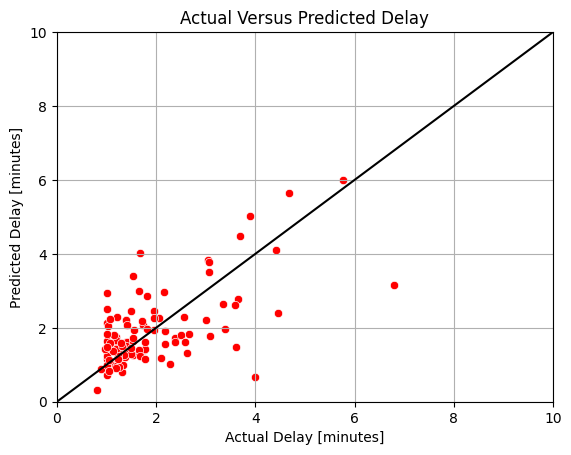

In [22]:
#Graphing pred vs true
delay_graph = sns.scatterplot(
    x=y_test_delay,
    y=y_pred[0].flatten(),
    color='red',
    marker='o'
)
theor = np.linspace(0, 10)
plt.plot(theor, theor, linestyle='-', color='black')
plt.grid(True)
plt.xlim(0, 10)
plt.ylim(0, 10)
delay_graph.set(
    title='Actual Versus Predicted Delay',
    ylabel='Predicted Delay [minutes]',
    xlabel='Actual Delay [minutes]'
)
plt.show()

plt.close()

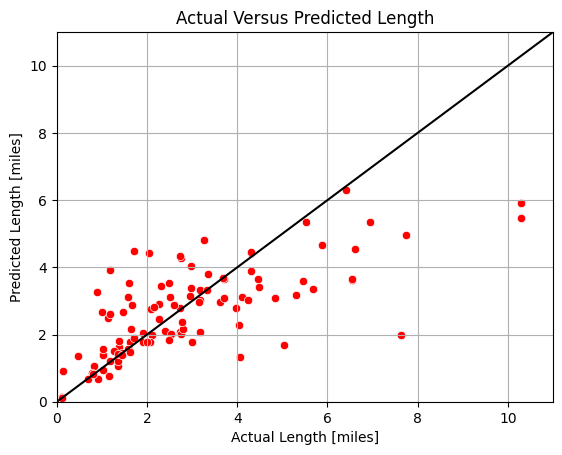

In [ ]:
#Graphing pred vs true
length_graph = sns.scatterplot(
    x=y_test_length,
    y=y_pred[1].flatten(),
    color='red',
    marker='o'
)
theor = np.linspace(0, 11)
plt.plot(theor, theor, linestyle='-', color='black')
plt.grid(True)
plt.xlim(0, 11)
plt.ylim(0, 11)
length_graph.set(
    title='Actual Versus Predicted Length',
    ylabel='Predicted Length [miles]',
    xlabel='Actual Length [miles]'
)
plt.show()

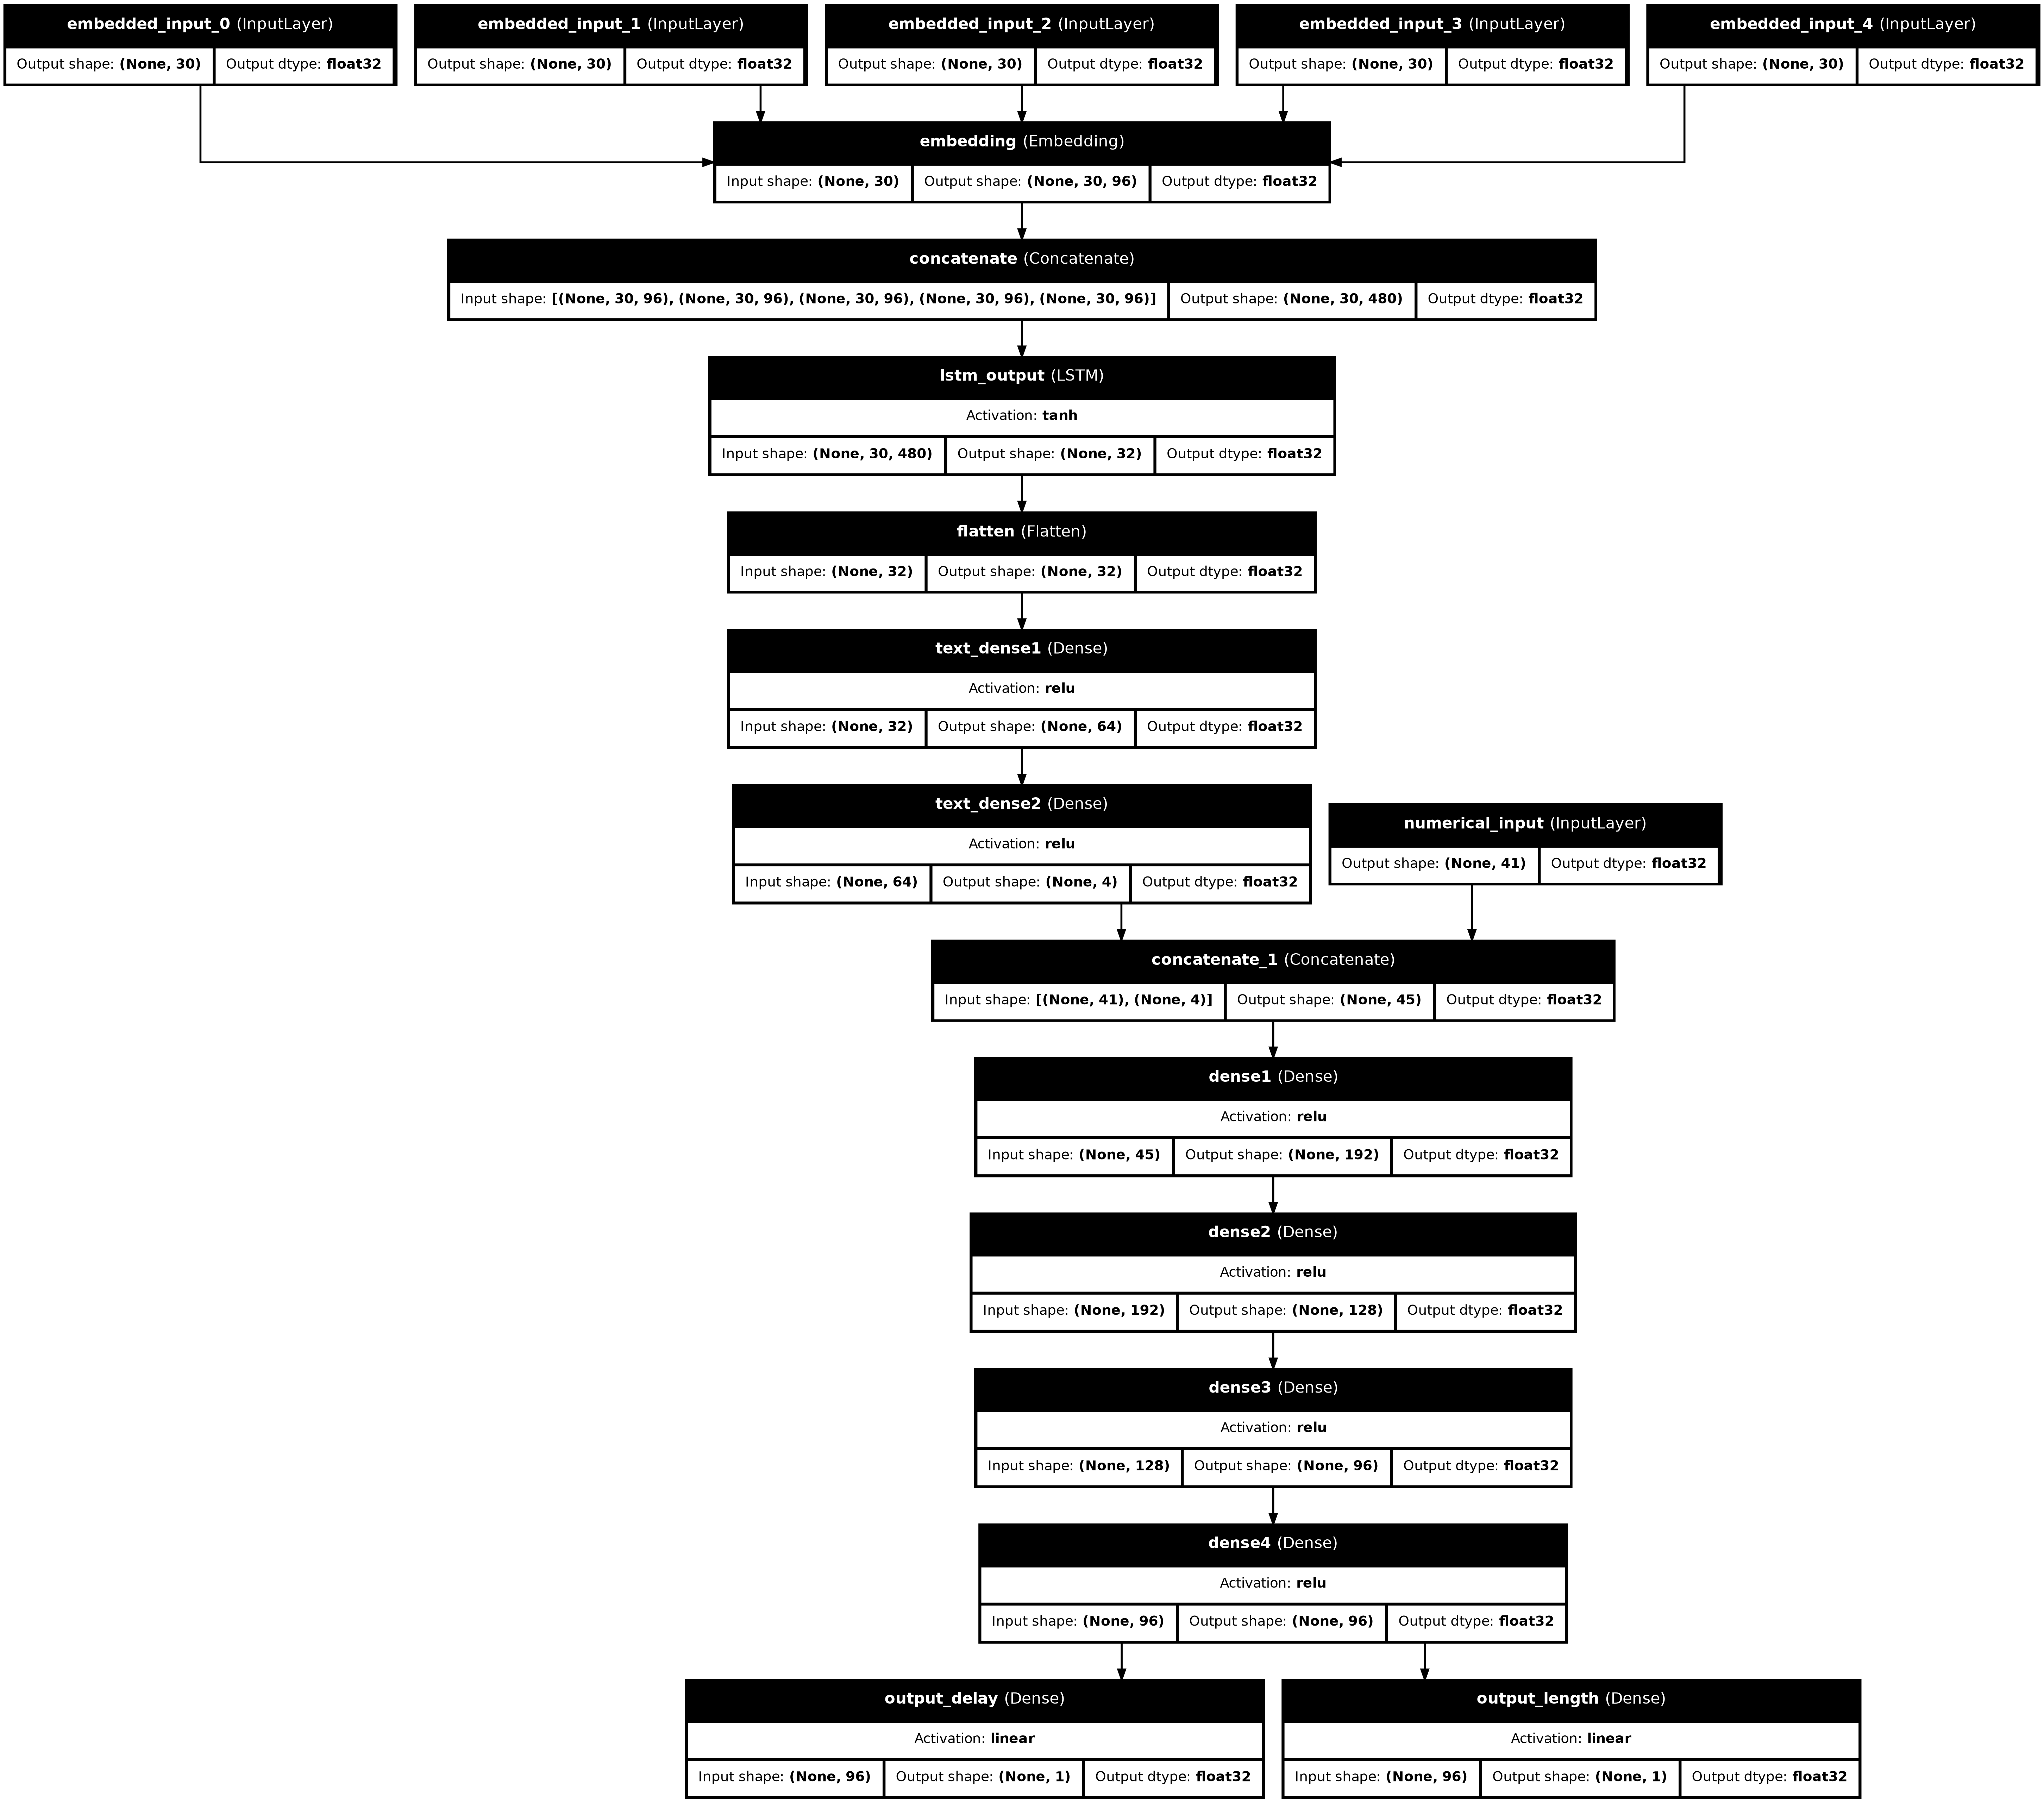

In [14]:
tf.keras.utils.plot_model(model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    expand_nested=True,
    show_layer_activations=True)

In [ ]:
numerical_input = keras.layers.Input(shape=(len(num_col),), name='numerical_input')

# Textual input layers
embedded_inputs = [keras.layers.Input(shape=(max_length,), name=f'embedded_input_{i}') for i in range(len(TEXT_COLUMNS))]

# Embedding layer
embedding_dim = 96
embedding_layer = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)

# Embed each text column
embedded_sequences = [embedding_layer(embed_input) for embed_input in embedded_inputs]

# Concatenate embedded sequences
concatenated_embedding = keras.layers.Concatenate()(embedded_sequences)

# LSTM layer
lstm_units = 32
lstm_output = keras.layers.LSTM(lstm_units, name='lstm_output')(concatenated_embedding)
flatten = keras.layers.Flatten()(lstm_output)
text_dense1 = keras.layers.Dense(64, activation='relu', name='text_dense1')(flatten)
text_dense2 = keras.layers.Dense(4, activation='relu', name='text_dense2')(text_dense1)

# Combine text and numerical features
all_features = keras.layers.Concatenate()([numerical_input, text_dense2])

# Dense layers
dense1 = keras.layers.Dense(192, activation='relu', name='dense1')(all_features)
dense2 = keras.layers.Dense(128, activation='relu', name='dense2')(dense1)
dense3 = keras.layers.Dense(96, activation='relu', name='dense3')(dense2)
dense4 = keras.layers.Dense(96, activation='relu', name='dense4')(dense3)

# Output layers
output_delay = keras.layers.Dense(1, activation='linear', name='output_delay')(dense4)
output_length = keras.layers.Dense(1, activation='linear', name='output_length')(dense4)

# Define the model
model = keras.models.Model(inputs=[numerical_input] + embedded_inputs, outputs=[output_delay, output_length])

# Determine optimal optimizer setup
optimizer = keras.optimizers.Adam(learning_rate=5e-5)

# Compile the model
model.compile(
    optimizer=optimizer, 
    loss={
        'output_delay': 'mean_squared_error',
        'output_length': 'mean_squared_error'
    },
    metrics={
        'output_delay':[
            keras.metrics.MeanSquaredError(name='mse_delay'), 
            keras.metrics.RootMeanSquaredError(name='rmse_delay'),
            keras.metrics.MeanAbsoluteError(name='mae_delay'),
        ],
        'output_length':[
            keras.metrics.MeanSquaredError(name='mse_length'),
            keras.metrics.RootMeanSquaredError(name='rmse_length'),
            keras.metrics.MeanAbsoluteError(name='mae_length')
        ]
    }
)

/home/abc0140/miniconda3/envs/QueueEstimation/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


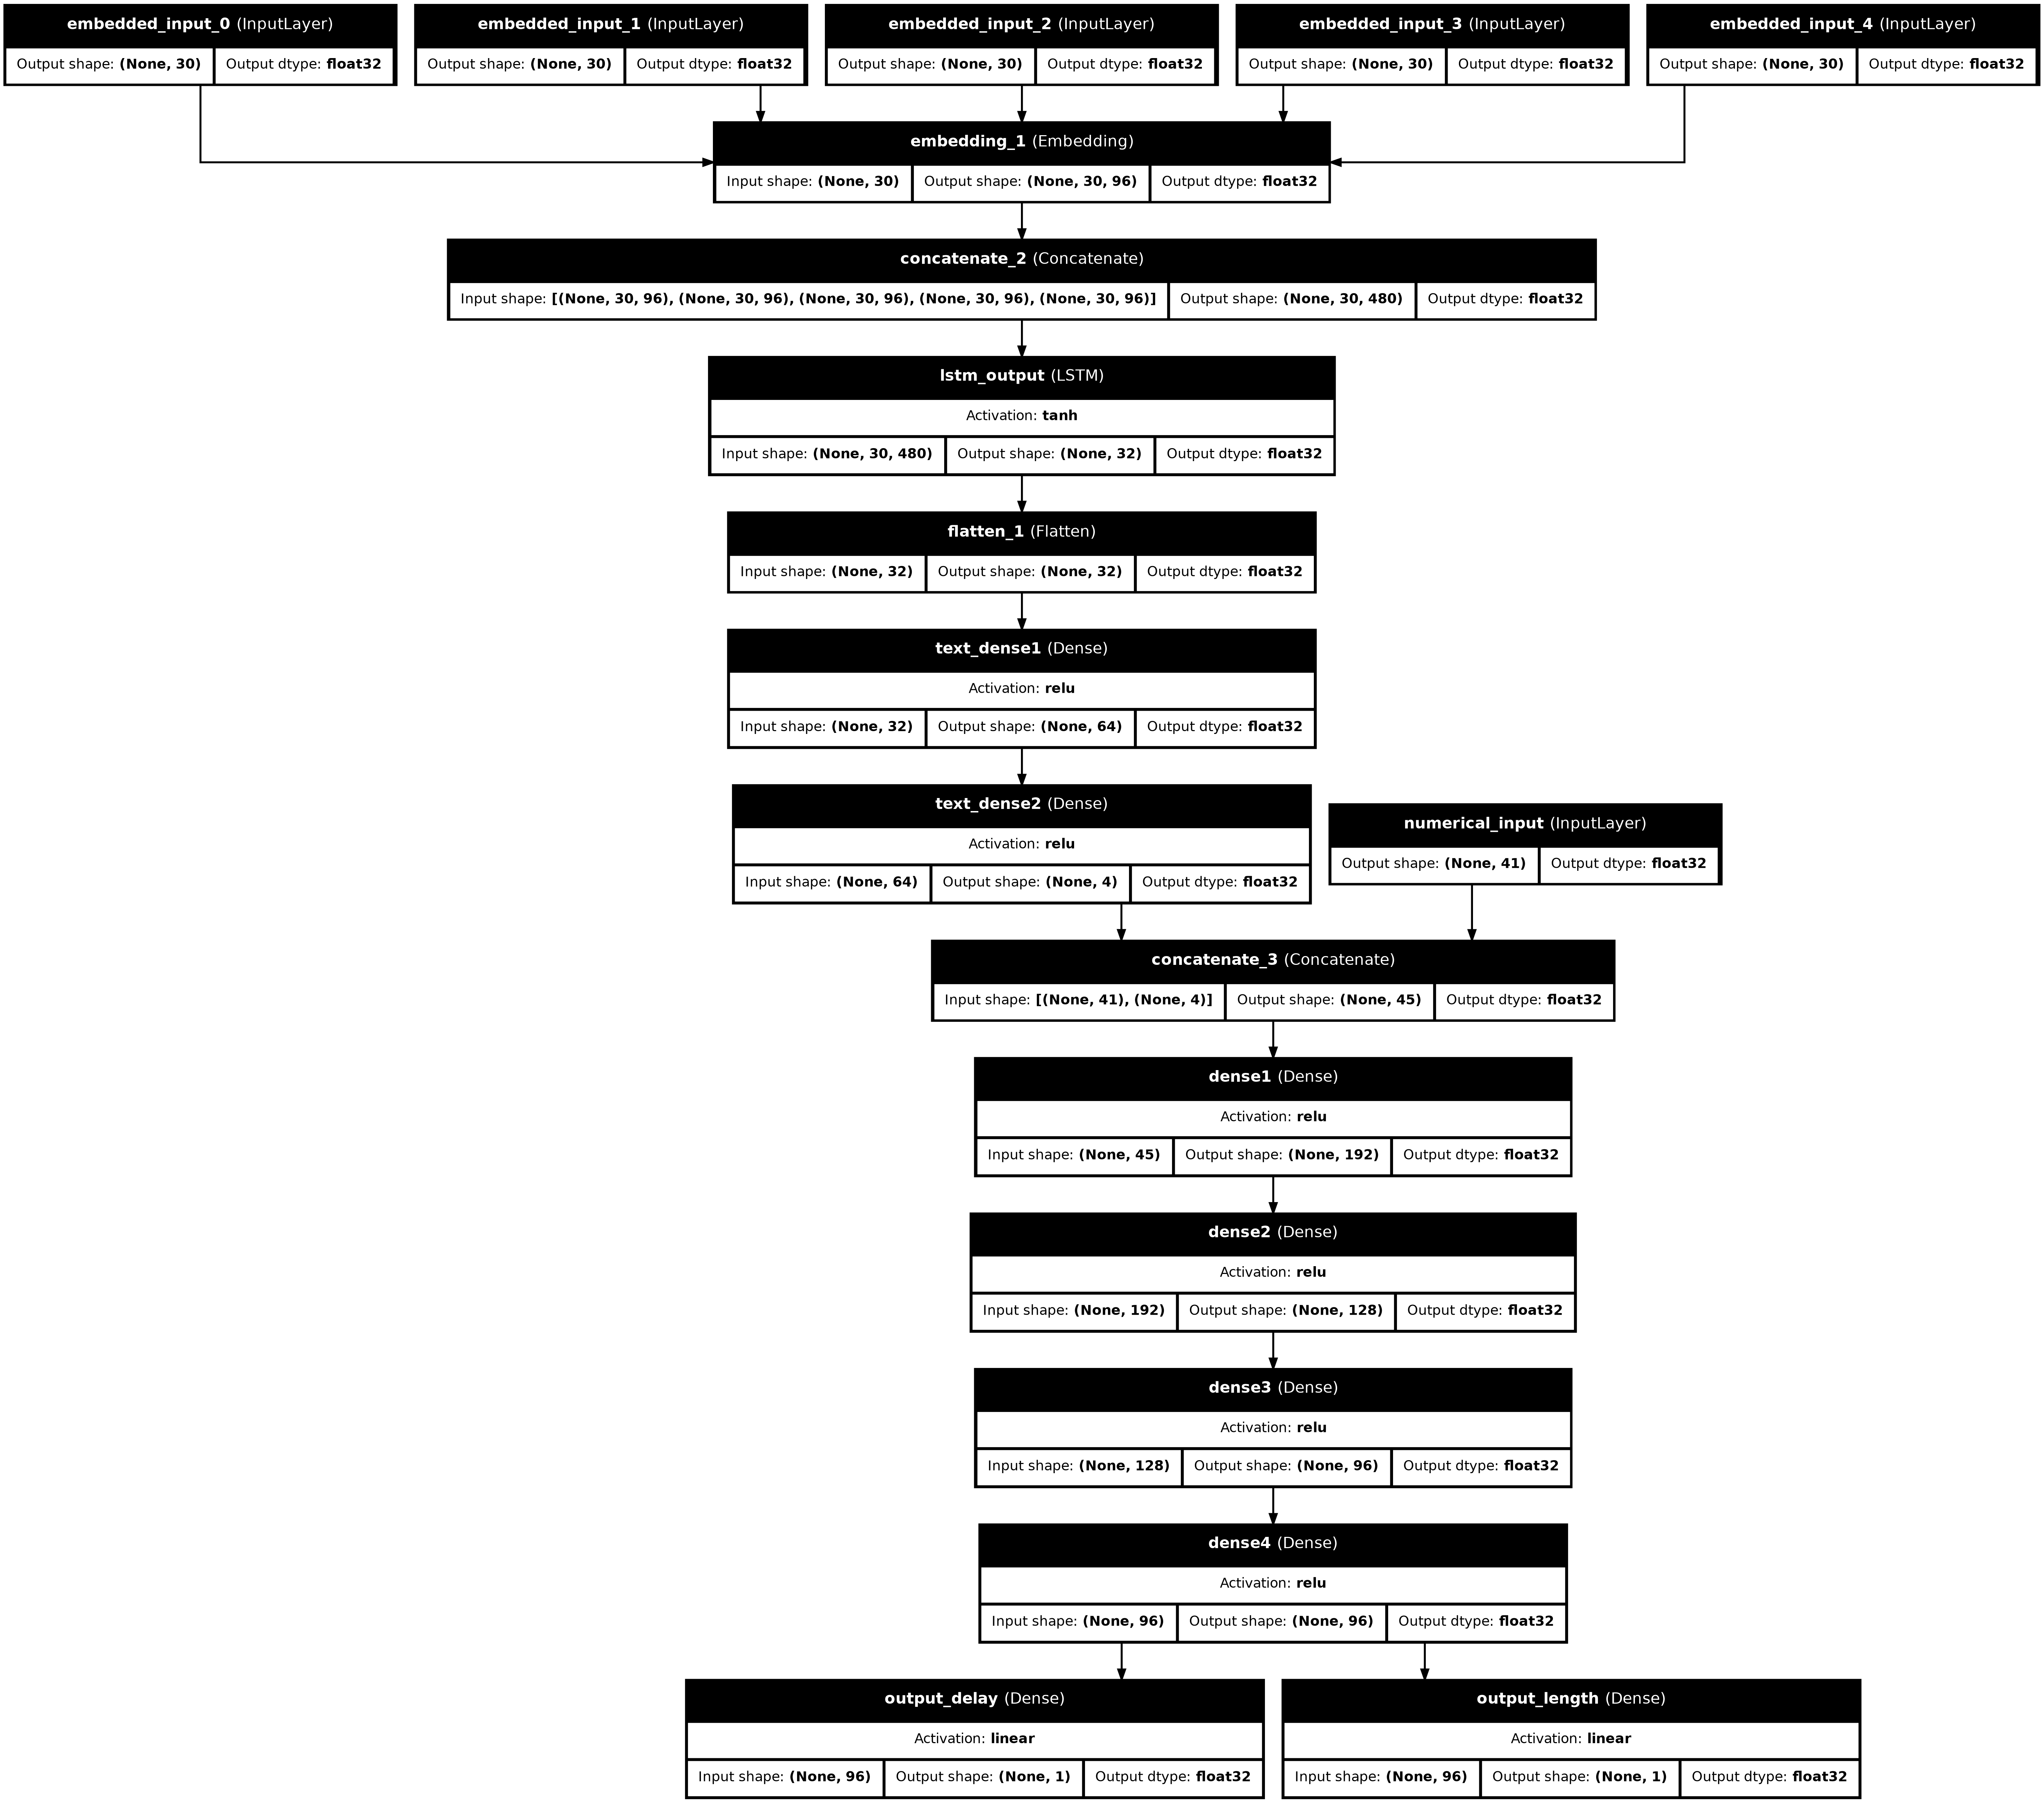

In [18]:
tf.keras.utils.plot_model(model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    expand_nested=True,
    show_layer_activations=True)

In [19]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                        patience=50,
                                        restore_best_weights=True)

model.fit(
        [x_numerical_train] + x_text_train_list,
        {'output_delay': y_train_delay, 'output_length': y_train_length},
        epochs=1000,
        validation_data=[[x_numerical_test] + x_text_test_list, {'output_delay': y_test_delay, 'output_length': y_test_length}],
        callbacks=[callback]
    )


Epoch 1/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 19.9551 - output_delay_loss: 9.3079 - output_delay_mae_delay: 2.0324 - output_delay_mse_delay: 9.4295 - output_delay_rmse_delay: 2.9334 - output_length_loss: 10.4947 - output_length_mae_length: 2.7512 - output_length_mse_length: 10.5256 - output_length_rmse_length: 3.2431 - val_loss: 17.3360 - val_output_delay_loss: 4.7573 - val_output_delay_mae_delay: 1.9027 - val_output_delay_mse_delay: 5.3219 - val_output_delay_rmse_delay: 2.3069 - val_output_length_loss: 10.6372 - val_output_length_mae_length: 2.8190 - val_output_length_mse_length: 12.0141 - val_output_length_rmse_length: 3.4661
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 27.4311 - output_delay_loss: 18.8087 - output_delay_mae_delay: 2.1345 - output_delay_mse_delay: 18.9172 - output_delay_rmse_delay: 4.3155 - output_length_loss: 8.4620 - output_length_mae_length: 2.4677 - output_length_mse_length: 8.5139 - output_length_rmse_length: 2.9155 - val_loss: 16.

In [20]:
model.evaluate([x_numerical_test] + x_text_test_list, {'output_delay': y_test_delay, 'output_length': y_test_length})

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 2.9679 - output_delay_loss: 0.8075 - output_delay_mae_delay: 0.6486 - output_delay_mse_delay: 0.8472 - output_delay_rmse_delay: 0.9203 - output_length_loss: 2.0296 - output_length_mae_length: 0.9389 - output_length_mse_length: 2.1207 - output_length_rmse_length: 1.4548


[2.869598150253296,
 0.7357896566390991,
 1.806809663772583,
 0.6409441232681274,
 0.8351795077323914,
 0.9138815999031067,
 0.9326286315917969,
 2.0344185829162598,
 1.4263304471969604]

Let's try a transformer

In [ ]:
TEXT_COLUMNS

['CollisionT', 'CrashType', 'TrafficCon', 'CountyName', 'CityTownNa']

In [55]:
np.array(x_text_train_list).shape

(5, 421, 30)

In [60]:
np.unique(x_text_train_list[0])

array([  0,   3,   5,  11,  12,  15,  43,  44,  59,  60, 115, 116, 117,
       143, 158], dtype=int32)

In [7]:
def AutoEncoder(NN,baseUnits=256,dropout = 0.1,includeFirst = True):
    if includeFirst:
        NN = tf.keras.layers.Dense(units=int(baseUnits*4), activation='relu')(NN)
        NN = tf.keras.layers.Dropout(dropout*4)(NN)

    NN = tf.keras.layers.Dense(units=int(baseUnits*2), activation='relu')(NN)
    NN = tf.keras.layers.Dropout(dropout*2)(NN)
    NN = tf.keras.layers.Dense(units=baseUnits, activation='relu')(NN)
    NN = tf.keras.layers.Dropout(dropout)(NN)
    NN = tf.keras.layers.Dense(units=int(baseUnits*2), activation='relu')(NN)
    NN = tf.keras.layers.Dropout(dropout*2)(NN)
    NN = tf.keras.layers.Dense(units=int(baseUnits*4), activation='relu')(NN)
    NN = tf.keras.layers.Dropout(dropout*4)(NN)
    return NN

def AE_Stack(NN,unitList,dropout_list):
    for i in range(len(unitList)):
        if i == 0:
            NN = AutoEncoder(NN,unitList[i],dropout_list[i],includeFirst=True)
        else:
            NN = AutoEncoder(NN,unitList[i],dropout_list[i],includeFirst=False)

    return NN
from tensorflow.keras import layers

class GatedLinearUnit(layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.linear = layers.Dense(units)
        self.sigmoid = layers.Dense(units, activation="sigmoid")

    def call(self, inputs):
        return self.linear(inputs) * self.sigmoid(inputs)

class GatedResidualNetwork(layers.Layer):
    def __init__(self, units, dropout_rate):
        super().__init__()
        self.units = units
        self.elu_dense = layers.Dense(units, activation="elu")
        self.linear_dense = layers.Dense(units)
        self.dropout = layers.Dropout(dropout_rate)
        self.gated_linear_unit = GatedLinearUnit(units)
        self.layer_norm = layers.LayerNormalization()
        self.project = layers.Dense(units)

    def call(self, inputs):
        x = self.elu_dense(inputs)
        x = self.linear_dense(x)
        x = self.dropout(x)
        if inputs.shape[-1] != self.units:
            inputs = self.project(inputs)
        x = inputs + self.gated_linear_unit(x)
        x = self.layer_norm(x)
        return x

def AE_GRN(NN, units, dropout):
    AE = AutoEncoder(NN,baseUnits=units,dropout=dropout)

    GLU = GatedLinearUnit(units)(AE)

    GRN = GatedResidualNetwork(units,dropout)(NN)

    AAN = layers.Add()([GLU,GRN])

    AAN = layers.LayerNormalization()(AAN)

    return AAN

In [8]:
AUTOTUNE = tf.data.AUTOTUNE



X_Train = tuple(tf.data.Dataset.from_tensor_slices(x) for x in [x_numerical_train] + x_text_train_list)
y_train = tuple(tf.data.Dataset.from_tensor_slices(y) for y in [y_train_delay, y_train_length])

trainTFDS = tf.data.Dataset.zip((X_Train, y_train)).cache().shuffle(16, reshuffle_each_iteration=True).prefetch(buffer_size=AUTOTUNE).batch(16)

X_Test = tuple(tf.data.Dataset.from_tensor_slices(x) for x in [x_numerical_test] + x_text_test_list)
y_test = tuple(tf.data.Dataset.from_tensor_slices(y) for y in [y_test_delay, y_test_length])

testTFDS = tf.data.Dataset.zip((X_Test, y_test)).cache().prefetch(buffer_size=AUTOTUNE).batch(16)



I0000 00:00:1743107639.886526 4015027 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13512 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9


In [32]:
dropout = 0.1
Nodes = 256

numerical_input = keras.layers.Input(shape=(len(num_col),), name='numerical_input')

# Textual input layers
embedded_inputs = [keras.layers.Input(shape=(max_length,), name=f'embedded_input_{i}') for i in range(len(TEXT_COLUMNS))]

# Embedding layer
embedding_dim = 16
embedding_layer = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)

# Embed each text column
embedded_sequences = [embedding_layer(embed_input) for embed_input in embedded_inputs]

# Concatenate embedded sequences
concatenated_embedding = keras.layers.Concatenate()(embedded_sequences)

#multi-headed attention layer (input shape is (None, 30, 480))
attention = keras.layers.MultiHeadAttention(num_heads=4, key_dim=16)(concatenated_embedding, concatenated_embedding)

#normalize the attention outputs
attention = keras.layers.LayerNormalization()(attention)

flatten = keras.layers.Flatten()(attention)

AE_GRN0_TEXT = AE_GRN(flatten, Nodes, dropout)

# Combine text and numerical features

AE_GRN0_NUMERIC = AE_GRN(numerical_input, Nodes, dropout)

all_features = keras.layers.Concatenate()([AE_GRN0_NUMERIC, AE_GRN0_TEXT])

#autoencoder with GRN

AE_GRN1 = AE_GRN(all_features, Nodes, dropout)

AE_GRN2 = AE_GRN(AE_GRN1, Nodes, dropout)

# AE_GRN3 = AE_GRN(AE_GRN2, Nodes, dropout)

# AE_GRN4 = AE_GRN(AE_GRN3, Nodes, dropout)

final_layer = keras.layers.Dense(Nodes, activation='relu', name='final_layer')(AE_GRN2)
# Output layers
output_delay = keras.layers.Dense(1, activation='linear', name='output_delay_initial')(final_layer)
output_length = keras.layers.Dense(1, activation='linear', name='output_length_initial')(final_layer)

# glu_length = GatedLinearUnit(1)(output_length)
# glu_delay = GatedLinearUnit(1)(output_delay)
# glu_numeric = GatedLinearUnit(1)(numerical_input)
# glu_text = GatedLinearUnit(1)(flatten)

# grn_length = GatedResidualNetwork(1,0)(output_length)
# grn_delay = GatedResidualNetwork(1,0)(output_delay)

# grn_numeric_delay = GatedResidualNetwork(1,0)(numerical_input)
# grn_numeric_length = GatedResidualNetwork(1,0)(flatten)
# grn_text_delay = GatedResidualNetwork(1,0)(flatten)
# grn_text_length = GatedResidualNetwork(1,0)(numerical_input)

# OutputFactorsDelay = keras.layers.Concatenate()([output_delay, grn_length, grn_numeric_delay, grn_text_delay])
# OutputFactorsLength = keras.layers.Concatenate()([output_length, grn_delay, grn_numeric_length, grn_text_length])

grn_numeric = GatedResidualNetwork(1,0)(numerical_input)
grn_text = GatedResidualNetwork(1,0)(flatten)

Outputs = keras.layers.Concatenate()([output_delay, output_length, grn_numeric, grn_text])

output_delay = keras.layers.Dense(1, activation='linear', name='output_delay')(Outputs)
output_length = keras.layers.Dense(1, activation='linear', name='output_length')(Outputs)
# Define the model
model = keras.models.Model(inputs=[numerical_input] + embedded_inputs, outputs=[output_delay, output_length])

# Determine optimal optimizer setup
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

# Compile the model
model.compile(
    optimizer=optimizer, 
    loss={
        'output_delay': 'mean_squared_error',
        'output_length': 'mean_squared_error'
    },
    metrics={
        'output_delay':[
            keras.metrics.MeanSquaredError(name='mse_delay'), 
            keras.metrics.RootMeanSquaredError(name='rmse_delay'),
            keras.metrics.MeanAbsoluteError(name='mae_delay'),
        ],
        'output_length':[
            keras.metrics.MeanSquaredError(name='mse_length'),
            keras.metrics.RootMeanSquaredError(name='rmse_length'),
            keras.metrics.MeanAbsoluteError(name='mae_length')
        ]
    },
    weighted_metrics={
        'output_delay':[
            keras.metrics.MeanSquaredError(name='mse_delay'), 
            keras.metrics.RootMeanSquaredError(name='rmse_delay'),
            keras.metrics.MeanAbsoluteError(name='mae_delay'),
        ],
        'output_length':[
            keras.metrics.MeanSquaredError(name='mse_length'),
            keras.metrics.RootMeanSquaredError(name='rmse_length'),
            keras.metrics.MeanAbsoluteError(name='mae_length')
        ]
    }
)

/home/abc0140/miniconda3/envs/QueueEstimation/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/home/abc0140/miniconda3/envs/QueueEstimation/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'gated_residual_network_33', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [33]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                        patience=500,
                                        restore_best_weights=True)

model.fit(
        trainTFDS,
        epochs=2000,
        validation_data=testTFDS,
        callbacks=[callback]
    )


Epoch 1/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 690ms/step - loss: 21.4802 - output_delay_loss: 17.6155 - output_delay_mae_delay: 1.4041 - output_delay_mse_delay: 17.6378 - output_delay_rmse_delay: 4.0967 - output_delay_weighted_mae_delay: 1.4041 - output_delay_weighted_mse_delay: 17.6378 - output_delay_weighted_rmse_delay: 4.0967 - output_length_loss: 3.8386 - output_length_mae_length: 1.4469 - output_length_mse_length: 3.8424 - output_length_rmse_length: 1.9355 - output_length_weighted_mae_length: 1.4469 - output_length_weighted_mse_length: 3.8424 - output_length_weighted_rmse_length: 1.9355 - val_loss: 4.6284 - val_output_delay_loss: 1.4827 - val_output_delay_mae_delay: 0.8337 - val_output_delay_mse_delay: 1.5483 - val_output_delay_rmse_delay: 1.2443 - val_output_delay_weighted_mae_delay: 0.8337 - val_output_delay_weighted_mse_delay: 1.5483 - val_output_delay_weighted_rmse_delay: 1.2443 - val_output_length_loss: 2.9594 - val_output_length_mae_length: 1.2337 - val_output_length_mse_lengt

In [39]:
model.evaluate([x_numerical_test] + x_text_test_list, {'output_delay': y_test_delay, 'output_length': y_test_length})

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.4823 - output_delay_loss: 0.6843 - output_delay_mae_delay: 0.5798 - output_delay_mse_delay: 0.7023 - output_delay_rmse_delay: 0.8380 - output_delay_weighted_mae_delay: 0.5798 - output_delay_weighted_mse_delay: 0.7023 - output_delay_weighted_rmse_delay: 0.8380 - output_length_loss: 1.6916 - output_length_mae_length: 0.9019 - output_length_mse_length: 1.7800 - output_length_rmse_length: 1.3337 - output_length_weighted_mae_length: 0.9019 - output_length_weighted_mse_length: 1.7800 - output_length_weighted_rmse_length: 1.3337


[2.50458025932312,
 0.6576776504516602,
 1.580861210823059,
 0.5780391097068787,
 0.7027431726455688,
 0.8382977843284607,
 0.5780391097068787,
 0.7027431726455688,
 0.8382977843284607,
 0.890758752822876,
 1.8018369674682617,
 1.342325210571289,
 0.890758752822876,
 1.8018369674682617,
 1.342325210571289]

In [35]:
#Computer r2 scores for delay and length separately
y_true = [[i, j] for i, j in zip(y_test_delay.values, y_test_length.values)]
y_pred = model.predict([x_numerical_test] + x_text_test_list)
r2_delay = r2_score(y_test_delay, y_pred[0])
r2_length = r2_score(y_test_length, y_pred[1])

mape_delay = mean_absolute_percentage_error(y_test_delay, y_pred[0])
mape_length = mean_absolute_percentage_error(y_test_length, y_pred[1])

# Quick and dirty metrics for the paper
print(f'MAPE FOR MODEL\nDelay: {mape_delay}\nLength: {mape_length}')
print(f'\nR^2 FOR MODEL\nDelay: {r2_delay}\nLength: {r2_length}')
delay_under = y_pred[0].flatten() < y_test_delay
delay_under = round(np.mean(delay_under) * 100, 2)
print(f'DELAY predicts less than actual {delay_under}% of the time and over the actual {100 - delay_under}% of the time')
length_under = y_pred[1].flatten() < y_test_length
length_under = round(np.mean(length_under) * 100, 2)
print(f'LENGTH predicts less than actual {length_under}% of the time and over the acual {100 - length_under}% of the time')


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 728ms/step
MAPE FOR MODEL
Delay: 0.3173069117426722
Length: 0.39446878288194565

R^2 FOR MODEL
Delay: 0.5910207802617431
Length: 0.5524801752592893
DELAY predicts less than actual 45.28% of the time and over the actual 54.72% of the time
LENGTH predicts less than actual 42.45% of the time and over the acual 57.55% of the time


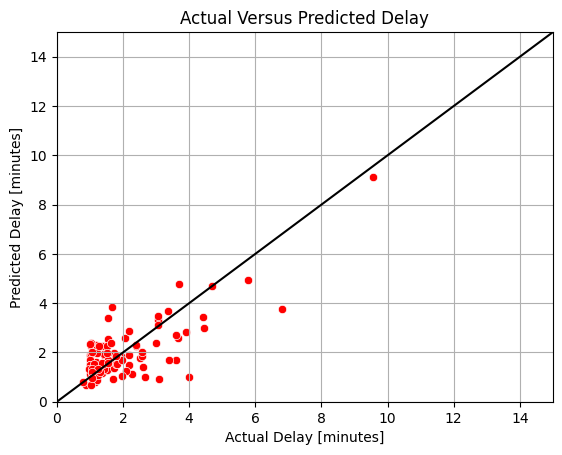

In [36]:
#Graphing pred vs true
delay_graph = sns.scatterplot(
    x=y_test_delay,
    y=y_pred[0].flatten(),
    color='red',
    marker='o'
)

limit = 15
theor = np.linspace(0, limit)
plt.plot(theor, theor, linestyle='-', color='black')
plt.grid(True)
plt.xlim(0, limit)
plt.ylim(0, limit)
delay_graph.set(
    title='Actual Versus Predicted Delay',
    ylabel='Predicted Delay [minutes]',
    xlabel='Actual Delay [minutes]'
)
plt.show()

plt.close()

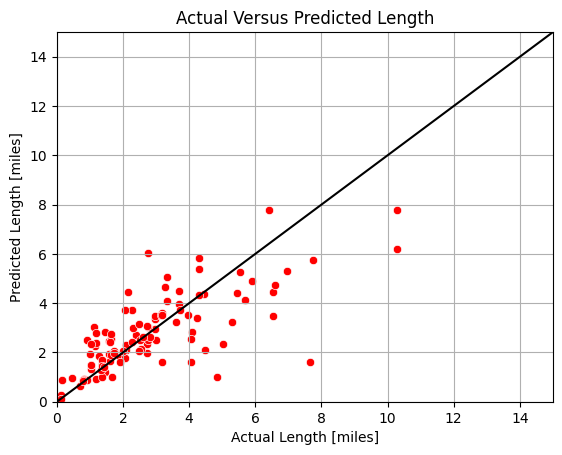

In [37]:
#Graphing pred vs true
length_graph = sns.scatterplot(
    x=y_test_length,
    y=y_pred[1].flatten(),
    color='red',
    marker='o'
)

limit = 15

theor = np.linspace(0, limit)
plt.plot(theor, theor, linestyle='-', color='black')
plt.grid(True)
plt.xlim(0, limit)
plt.ylim(0, limit)
length_graph.set(
    title='Actual Versus Predicted Length',
    ylabel='Predicted Length [miles]',
    xlabel='Actual Length [miles]'
)
plt.show()

In [38]:
tf.keras.utils.plot_model(model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    expand_nested=True,
    show_layer_activations=True)